# Week 2 — Equity Factors I (Momentum 12-1 & Value Proxy)

**Goal:** Build and compare two simple equity factors:
- Momentum (12-1)
- Value proxy (inverse PE)

Method: Monthly rebalance, equal-weight top-quantile portfolio; compare to SPY.

In [8]:
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

from src.utils.data import fetch_prices, to_month_end, pct_change
from src.factors.momentum import momentum_12_1, zscore
from src.factors.value import inverse_pe_snapshot
from src.portfolio.backtest import long_top_quantile, summary_from_equity

plt.rcParams["figure.figsize"] = (10,4)
pd.options.display.float_format = "{:,.4f}".format

In [10]:
universe = [
    "AAPL","MSFT","AMZN","GOOGL","META",
    "NVDA","BRK-B","JPM","V","HD",
    "PG","JNJ","XOM","UNH","MA",
    "AVGO","LLY","PEP","WMT","KO"
]
start = "2015-01-01"

prices = fetch_prices(universe, start=start)
prices = prices.dropna(axis=1, how="any")  # ensure clean columns
prices_m = to_month_end(prices)

spy = fetch_prices(["SPY"], start=start)["SPY"]
spy_m = to_month_end(spy.to_frame())["SPY"]

/Users/siyaoli/Documents/Git_quant_experience/quant-experience-portfolio/src/utils/data.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return prices.resample("M").last()
/Users/siyaoli/Documents/Git_quant_experience/quant-experience-portfolio/src/utils/data.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return prices.resample("M").last()


In [11]:
# Momentum 12-1 on monthly data
mom = momentum_12_1(prices_m, monthly=True)
mom_z = zscore(mom)  # cross-sectional standardization each month
# Value proxy (inverse PE) is a point-in-time snapshot; reuse it each month
inv_pe = inverse_pe_snapshot(list(prices_m.columns))
# Build a monthly DataFrame repeating the snapshot (toy demo)
val_proxy = pd.DataFrame(
    np.repeat(inv_pe.values.reshape(1,-1), len(prices_m.index), axis=0),
    index=prices_m.index,
    columns=prices_m.columns,
)
val_z = zscore(val_proxy)

In [12]:
# Momentum top-quantile
eq_mom = long_top_quantile(prices_m, mom_z, quantile=0.8, cost_bps=5.0)
# Value top-quantile
eq_val = long_top_quantile(prices_m, val_z, quantile=0.8, cost_bps=5.0)

# SPY benchmark on month-end
spy_rets_m = spy_m.pct_change().fillna(0)
eq_spy = (1 + spy_rets_m).cumprod()
eq_spy.name = "SPY"

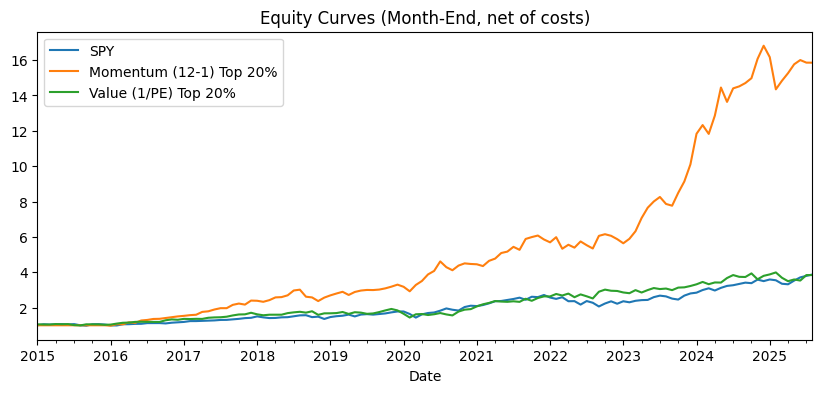

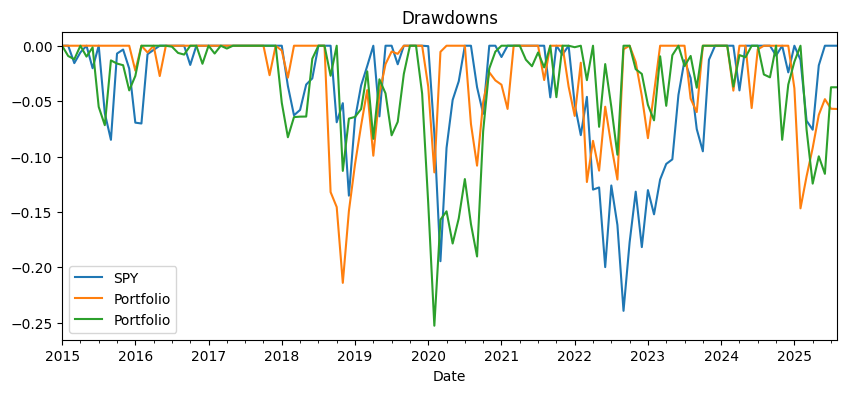

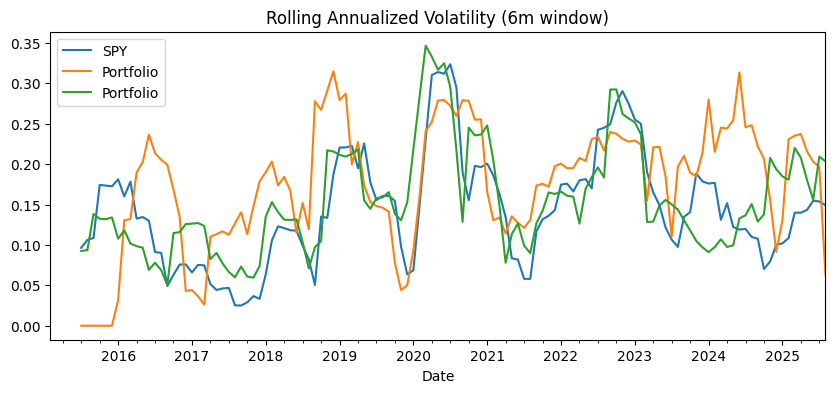

In [15]:
ax = eq_spy.plot(label="SPY")
eq_mom.plot(ax=ax, label="Momentum (12-1) Top 20%")
eq_val.plot(ax=ax, label="Value (1/PE) Top 20%")
plt.title("Equity Curves (Month-End, net of costs)")
plt.legend()
plt.show()

# Drawdowns
for ser in [eq_spy, eq_mom, eq_val]:
    dd = ser / ser.cummax() - 1
    dd.plot(label=ser.name)
plt.title("Drawdowns")
plt.legend(); plt.show()

# Rolling Volatility (6-month window, annualized)
for ser in [eq_spy, eq_mom, eq_val]:
    rets = ser.pct_change().dropna()
    vol = rets.rolling(window=6).std() * np.sqrt(12)  # monthly data → annualize with sqrt(12)
    vol.plot(label=ser.name)
plt.title("Rolling Annualized Volatility (6m window)")
plt.legend(); plt.show()


In [14]:
def monthly_perf_summary(equity, name):
    s = summary_from_equity(equity)
    return pd.Series({
        "Ann.Return": s["ann_return"],
        "Ann.Vol":    s["ann_vol"],
        "Sharpe":     s["sharpe"],
        "MaxDD":      s["max_drawdown"],
    }, name=name)

summary = pd.concat([
    monthly_perf_summary(eq_spy, "SPY"),
    monthly_perf_summary(eq_mom, "Momentum Top 20%"),
    monthly_perf_summary(eq_val, "Value Top 20%"),
], axis=1).T

summary.style.format({"Ann.Return":"{:.2%}", "Ann.Vol":"{:.2%}", "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"})

,Ann.Return,Ann.Vol,Sharpe,MaxDD
SPY,14.94%,15.17%,0.99,-23.93%
Momentum Top 20%,32.02%,18.71%,1.71,-21.40%
Value Top 20%,14.42%,16.00%,0.90,-25.27%


## Notes
- Momentum uses a classic 12-1 definition on month-end prices.
- Value is a simple inverse PE snapshot for demonstration; time-varying fundamentals would improve realism.
- Costs set to 5 bps per rebalance round-trip; sensitivity analysis is a good next step.

## Next
- Add Quality factor (e.g., gross profitability proxy) in Week 3.
- Test sector-neutral ranking.
- Add transaction-cost sensitivity and turnover stats.